In [ ]:
!pip install biosppy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.4 MB/s eta 0:00:00


In [ ]:
# import mne
import numpy as np
import pandas as pd
import librosa.display
import matplotlib.pyplot as plt

import pywt
from scipy.signal import butter, lfilter, savgol_filter
from scipy.interpolate import CubicSpline

from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_path = "/content/drive/MyDrive/DIS_Dr_Liu/"
small_X_path = folder_path + "small_X.npy"
small_y_path = folder_path + "small_y.npy"

In [ ]:
def pqrst_segmentation(input_file, patient_id, lead_id):
    '''
    Inputs:
        input_file: path to the numpy file, [str]
        patient_id: id of patient, [int]
        lead_id: lead range(0-11 inclusive). [int]
    Output:
        pqrst_data: 3D array
          where,
              1D: No. of heart beats/rpeaks detected
              2D: Indices of PQRST amplitudes
              3D: Amplitude of PQRST
          ,
        smoothed_ecg_data: 1D array
    -------------------------------------------
    For example:
    Inputs:
        input_file = './DIS/Datasets/small_X.npy'
        patient_id = 7
        lead_id = 1
    Output:
        array([[[ 1.50000000e+02,  1.26896875e+02],
            [ 1.86000000e+02, -4.25093750e+01],
            [ 1.99000000e+02,  3.07027679e+02],
            ...
            ]]]),
        array([194.76814516,  65.5378059 , -55.09052519, ...,  43.32979501,
        41.34527253,  38.91612903])
    '''
    # Load the ECG data from a file
    ecg_X = np.load(small_X_path, allow_pickle=True)

    # Extract the ECG data for the specified patient and lead
    X_ecg = ecg_X[patient_id, lead_id, :]

    # Smooth the ECG data using Savitzky-Golay filter
    smoothed_ecg_data = savgol_filter(X_ecg, window_length=30, polyorder=2)

    # Use the Christov's QRS complex detector to find R-peaks
    out = ecg.christov_segmenter(smoothed_ecg_data)
    r_peak_indices = list(out['rpeaks'])

    # Initialize lists to store Q, S, P, and T peak indices
    valid_r_peak_indices = []
    q_peak_indices = []
    s_peak_indices = []
    p_peak_indices = []
    t_peak_indices = []

    for r in r_peak_indices:
      # Search for Q-peak to the left of the R-peak
      q_peak = None
      for i in range(r - 1, 0, -1):
          # once the q-peak starts to raise this loop stops and latest q-peak is set to be the 'q'
          if smoothed_ecg_data[i] > smoothed_ecg_data[i + 1]:
              q_peak = i
              break

      # Search for S-peak to the right of the R-peak
      s_peak = None
      for i in range(r + 1, len(smoothed_ecg_data)):
          # once the s-valley starts to raise this loop stops and latest s-valley is set to be the 's'
          if smoothed_ecg_data[i] > smoothed_ecg_data[i - 1]:
              s_peak = i
              break
      q_peak_indices.append(q_peak)
      s_peak_indices.append(s_peak)
      valid_r_peak_indices.append(r)

      if q_peak is None or s_peak is None:
        # print("here")
        # print(r, q_peak, s_peak)
        valid_r_peak_indices.remove(r)
        q_peak_indices.remove(q_peak)
        s_peak_indices.remove(s_peak)
        continue

      p_peak_indices = []
      t_peak_indices = []
      for i in range(len(q_peak_indices)):
        try:
          # Assuming P-peak is at 100 samples before the Q-peak
          if len(p_peak_indices) == 0:
              # for the first ECG wave, P peak is set to be the highest point before the Q of that wave
              if q_peak_indices[i] - 100 < 0:
                  seg_ecg_signal = smoothed_ecg_data[:q_peak_indices[i]]
                  max_amplitude_index = np.argmax(seg_ecg_signal)
                  p_peak_indices.append(max_amplitude_index)
              else:
                  seg_ecg_signal = smoothed_ecg_data[q_peak_indices[i] - 100:q_peak_indices[i]]
                  max_amplitude_index = np.argmax(seg_ecg_signal)
                  p_peak_indices.append(q_peak_indices[i] - 100 + max_amplitude_index)
          # Otherwise, P peak is the highest point in a 100 sized search window before Q
          else:
              seg_ecg_signal = smoothed_ecg_data[q_peak_indices[i] - 100:q_peak_indices[i] - 25]
              max_amplitude_index = np.argmax(seg_ecg_signal)
              p_peak_indices.append(q_peak_indices[i] - 100 + max_amplitude_index)
        except Exception as E:
          valid_r_peak_indices.pop()
          q_peak_indices.pop()
          s_peak_indices.pop()
          continue

      for i in range(len(s_peak_indices)):
          try:
            # Assuming T-peak is at 200 samples After the S-peak
            # for the last ECG wave, T peak is set to be the highest point after the S of that wave
            if i + 1 == len(s_peak_indices):
                seg_ecg_signal = smoothed_ecg_data[s_peak_indices[i] + 25:]
                max_amplitude_index = np.argmax(seg_ecg_signal)
                t_peak_indices.append(s_peak_indices[i] + 25 + max_amplitude_index)
            # Otherwise, T peak is the highest point in a 200 sized search window after S
            else:
                seg_ecg_signal = smoothed_ecg_data[s_peak_indices[i] + 25:s_peak_indices[i] + 200]
                max_amplitude_index = np.argmax(seg_ecg_signal)
                t_peak_indices.append(s_peak_indices[i] + 25 + max_amplitude_index)
          except Exception as E:
            valid_r_peak_indices.pop()
            q_peak_indices.pop()
            s_peak_indices.pop()
            p_peak_indices.pop()

    # Create a 3D numpy array to store P, Q, R, S, and T peak indices and their corresponding amplitudes
    pqrst_data = np.zeros((len(valid_r_peak_indices), 5, 2))

    # Fill the array with P, Q, R, S, and T peak indices and their corresponding amplitudes
    for i in range(len(valid_r_peak_indices)):
        pqrst_data[i][0] = [p_peak_indices[i], smoothed_ecg_data[p_peak_indices[i]]]
        pqrst_data[i][1] = [q_peak_indices[i], smoothed_ecg_data[q_peak_indices[i]]]
        pqrst_data[i][2] = [valid_r_peak_indices[i], smoothed_ecg_data[valid_r_peak_indices[i]]]
        pqrst_data[i][3] = [s_peak_indices[i], smoothed_ecg_data[s_peak_indices[i]]]
        pqrst_data[i][4] = [t_peak_indices[i], smoothed_ecg_data[t_peak_indices[i]]]

    return pqrst_data, smoothed_ecg_data

In [ ]:
pqrst_segmentation_output, smoothed_ecg_data = pqrst_segmentation(small_X_path, 0, 1)

In [ ]:
def find_peaks(ecg_data, n):
  # to collect r peaks, n=2
  return int(ecg_data[n][0])

r_peak_indices = []
for ecg_data in pqrst_segmentation_output:
  r_peak_indices.append(find_peaks(ecg_data,2))

In [ ]:
def normalize_list(lst):
    min_val = min(lst)
    max_val = max(lst)
    normalized_lst = [(x - min_val) / (max_val - min_val) for x in lst]
    return normalized_lst
normalized_ecg = np.array(normalize_list(smoothed_ecg_data))

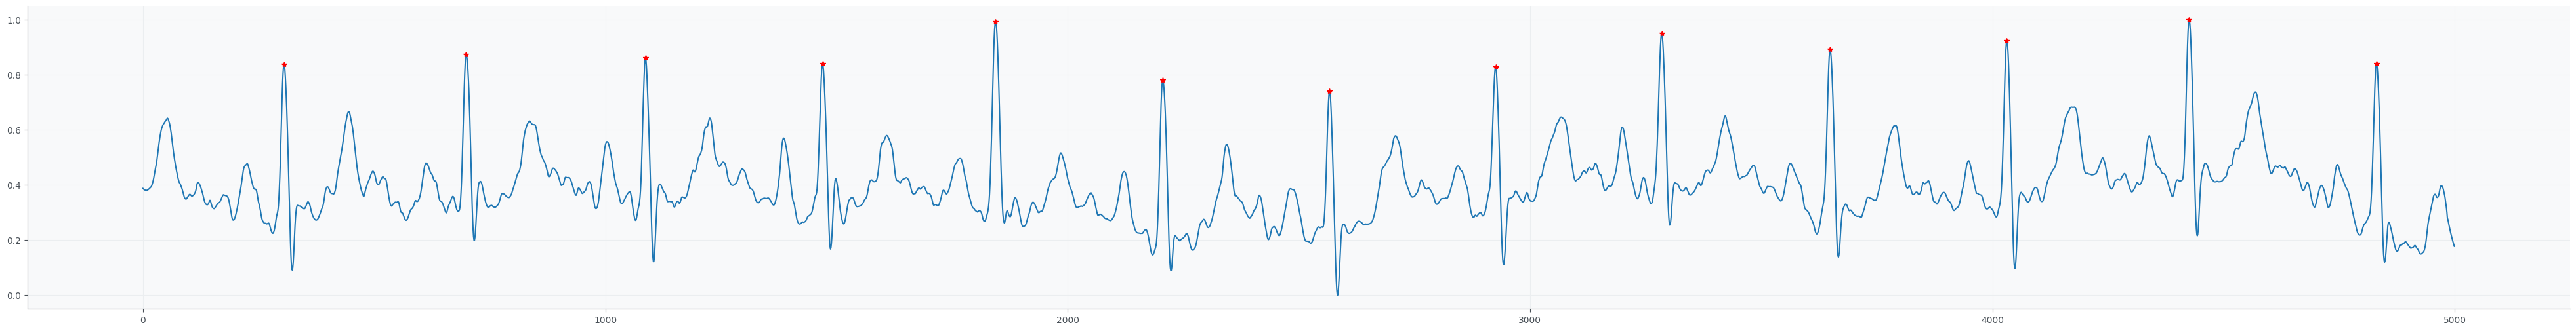

In [ ]:
plt.figure(figsize=(50, 6))
plt.plot(normalized_ecg)
plt.plot(r_peak_indices, normalized_ecg[r_peak_indices], 'r*', label='Detected R-Peaks')

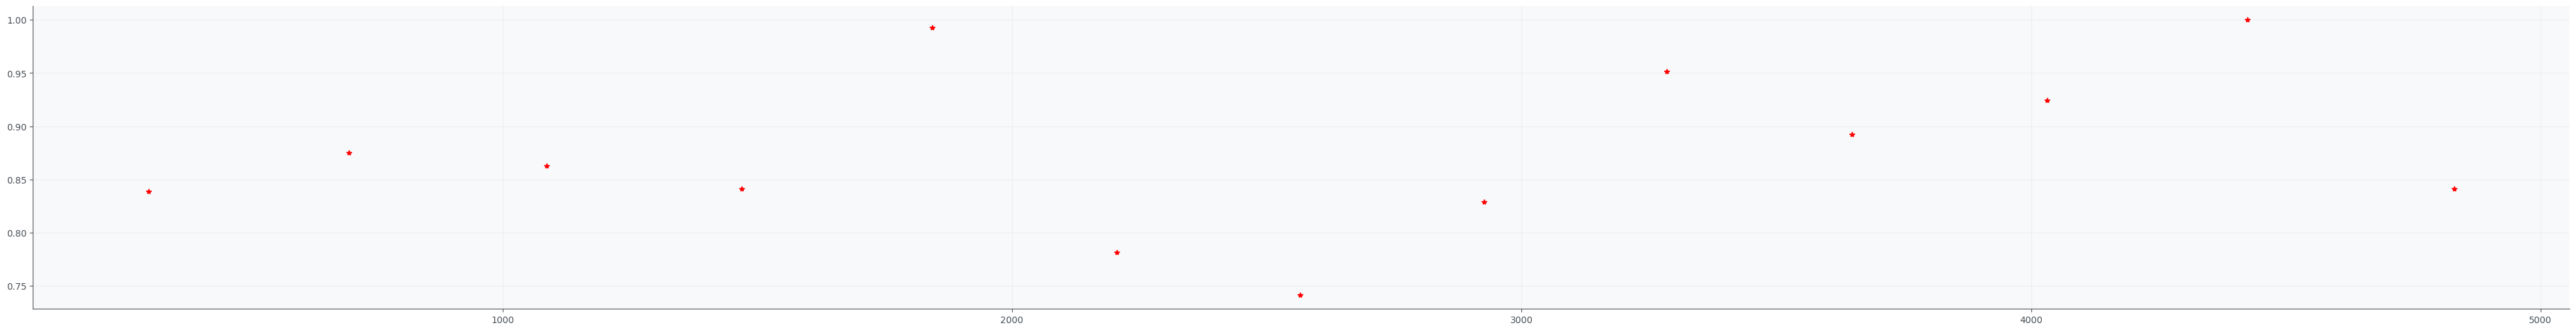

In [ ]:
plt.figure(figsize=(50, 6))
plt.plot(r_peak_indices, normalized_ecg[r_peak_indices], 'r*', label='Detected R-Peaks')

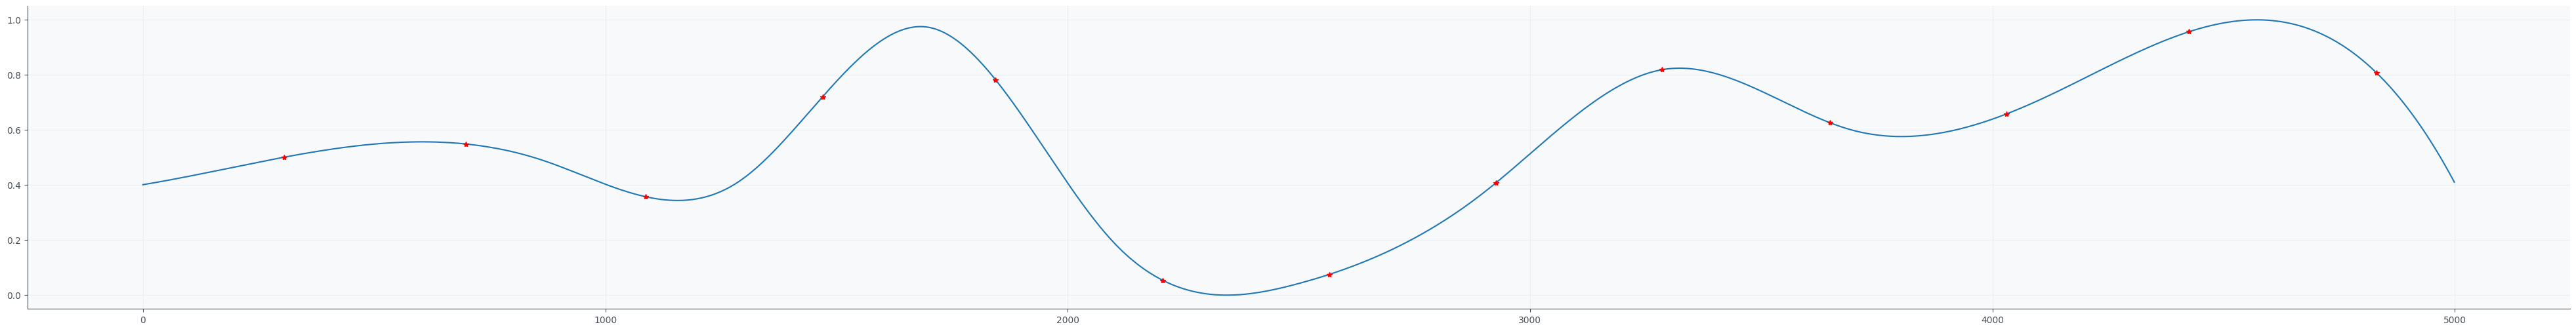

In [ ]:
x = np.array(r_peak_indices)
y = np.array(normalized_ecg[r_peak_indices])
cs = CubicSpline(x, y)

xs = np.linspace(min(x), max(x), 5000)
ys = cs(xs)
ys = np.array(normalize_list(ys))
y = np.array(ys[r_peak_indices])

plt.figure(figsize=(50, 6))
plt.plot(ys)
plt.plot(r_peak_indices, ys[r_peak_indices], 'r*', label='Detected R-Peaks')

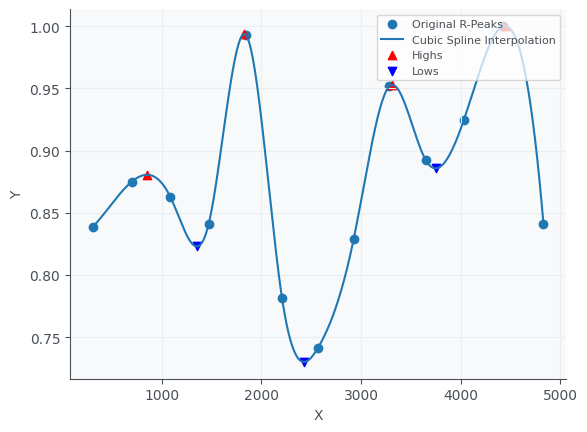

Highs: [851.8501700340067, 1826.9455891178234, 3313.5813162632526, 4443.496899379876]
Lows: [1351.620524104821, 2426.3078615723143, 3748.164232846569]


In [ ]:
x = np.array(r_peak_indices)
y = np.array(normalized_ecg[r_peak_indices])

cs = CubicSpline(x, y)

xs = np.linspace(min(x), max(x), 5000)
ys = cs(xs)

# Compute the first derivative of the cubic spline function
derivative_1 = cs.derivative()

# Generate points on the derivative curve
deriv_xs = np.linspace(min(x), max(x), 5000)
deriv_ys = derivative_1(deriv_xs)

# Find indices where the derivative changes sign
sign_changes = np.where(np.diff(np.sign(deriv_ys)))[0]

# Identify highs and lows based on the sign changes
highs = [deriv_xs[i] for i in sign_changes if deriv_ys[i] > 0]
lows = [deriv_xs[i] for i in sign_changes if deriv_ys[i] < 0]

# Plot the original points, cubic spline interpolation, and highs/lows
plt.scatter(x, y, label='Original R-Peaks')
plt.plot(xs, ys, label='Cubic Spline Interpolation')
plt.scatter(highs, cs(highs), c='red', marker='^', label='Highs')
plt.scatter(lows, cs(lows), c='blue', marker='v', label='Lows')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

# Print the identified highs and lows
print("Highs:", highs)
print("Lows:", lows)

In [ ]:
def cubic_spline_peaks_valleys(r_peak_indices, normalized_ecg):
  x = np.array(r_peak_indices)
  y = np.array(normalized_ecg[r_peak_indices])

  cs = CubicSpline(x, y)

  xs = np.linspace(min(x), max(x), 5000)
  ys = cs(xs)

  # Compute the first derivative of the cubic spline function
  derivative_1 = cs.derivative()

  # Generate points on the derivative curve
  deriv_xs = np.linspace(min(x), max(x), 5000)
  deriv_ys = derivative_1(deriv_xs)

  # Find indices where the derivative changes sign
  sign_changes = np.where(np.diff(np.sign(deriv_ys)))[0]

  # Identify highs and lows based on the sign changes
  highs = [deriv_xs[i] for i in sign_changes if deriv_ys[i] > 0]
  lows = [deriv_xs[i] for i in sign_changes if deriv_ys[i] < 0]

  return highs, lows, ys

## EDR Time Ratio

In [ ]:
def EDR_time_ratio(highs, lows):
  comp_lis = highs + lows
  st = sorted(comp_lis)

  TR = []
  for i in range(len(st)):
    try:
      if st[i] in lows and st[i+1] in highs and st[i+2] in lows:
        tr = (st[i+2] - st[i+1])/(st[i+1] - st[i])
        TR.append(tr)
    except Exception as e:
      continue
  tr = sum(TR)/len(TR)
  return tr

highs, lows, ys = cubic_spline_peaks_valleys(r_peak_indices, normalized_ecg)
tr = EDR_time_ratio(highs, lows)
tr

0.8753741496598643

## EDR Energy Ratio

In [ ]:
def integrand(t):
    return np.abs(np.interp(t, np.arange(len(ys)), ys))**2

def EDR_energy_ratio(highs, lows, ys):
  comp_lis = highs + lows
  st = sorted(comp_lis)

  EDR = []
  for i in range(len(st)):
    try:
      if st[i] in lows and st[i+1] in highs and st[i+2] in lows:
        exp, error = integrate.quad(integrand, st[i+1], st[i+2])
        ins, error = integrate.quad(integrand, st[i], st[i+1])
        EDR.append(exp/ins)
    except Exception as e:
      continue
  edr = sum(EDR)/len(EDR)
  return edr

highs, lows, ys = cubic_spline_peaks_valleys(r_peak_indices, normalized_ecg)
edr = EDR_energy_ratio(highs, lows, ys)
edr

<ipython-input-121-74751b98cbdb>:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  ins, error = integrate.quad(integrand, st[i], st[i+1])


0.7430657505120225

In [ ]:
np.trapz(ys**2)

1938.0396728156884

In [ ]:
def integrand(t):
    return np.abs(np.interp(t, np.arange(len(ys)), ys))**2

# Use the integrate function to perform the numerical integration
integral_result, error = integrate.quad(integrand, 0, len(ys)-1)

print("Numerical integration result:", integral_result)

Numerical integration result: 1938.0387975379238


<ipython-input-113-da8196d46bd9>:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral_result, error = integrate.quad(integrand, 0, len(ys)-1)


In [ ]:
integrand

<function __main__.integrand(y)>

In [ ]:
error

0.0004625929269271486

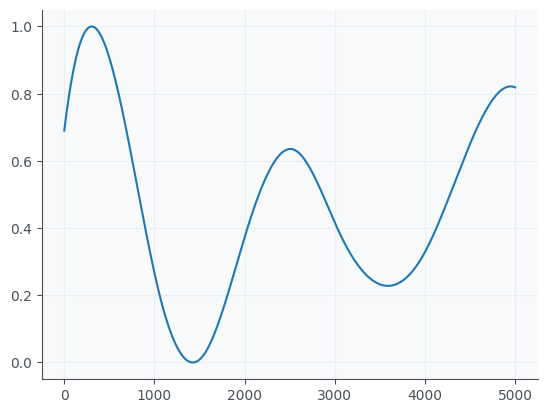

In [ ]:
plt.plot(ys)

In [ ]:
edr = np.trapz(ys**2)
edr

1457.9326164479812